#### Requirements and preamble

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from utils import vpt_smape, vpt_nrmse, vpt_mse, smape_rolling
from dysts.analysis import gp_dim
from dysts.metrics import estimate_kl_divergence
from scipy.stats import spearmanr

# from benchmark_utils import print_dict, score_ts
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline


%load_ext autoreload
%autoreload 2

/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/dysts/analysis.py:28: UserWarning: Sklearn not installed. Will not be able to use ridge regression for gpdistance and corr_gpdim.
  warnings.warn(


In [2]:
from scipy.spatial.distance import cdist

def delay_embedding(data, D=30, tau=1):
    """
    Create a delay embedding of a time series

    Args:
        data: 1D array representing the context trajectory
        D: embedding dimension
        tau: delay used for the embedding

    Returns:
        embedded_data: Delay embedded data

    Usage:
        arr = np.array([1,2,3,4,5,6,7,8,9])
        delay_embedding(arr,5,1)
    """
    N = len(data)
    indices = np.arange(D) * tau + np.arange(N - (D - 1) * tau)[:, None]
    embedded_data = data[indices]

    return embedded_data

def embedding_distance(data, D=30, tau=1):
    """
    Calculate the L2 distance in a delay-embedded space

    Args:
        data (array-like): 1D array representing the context trajectory
        D (int): Motif length, embedding dimension (default 30).
        tau (int): delay used for the embedding (default 1).

    Returns:
        min_l2_distance: Minimum L2 distance in the embedding space
    """

    # Create delay embeddings
    embedded_data = delay_embedding(data, D=D, tau=tau)

    # Compute distance of other points to the last point in the embedding space using L2 norm
    last_point = embedded_data[-1]
    l2_distance = cdist(embedded_data[:-D * tau], last_point[None, :])

    return l2_distance

In [3]:
def context_parroting_forecast(data, D=30, tau=1, forecast_total_length=300):
    """
    Simple forecasting model based on context parroting.

    Args:
        data (array-like): The input 1D array representing the context trajectory.
        D (int): Motif length, embedding dimension (default 30).
        tau (int): delay used for the embedding (default 1).
        forecast_total_length (int): Desired length of the forecasted output (default 300).

    Returns:
        best_index (int): Index of the best-matching context point.
        min_embedding_distance (float): Minimum L2 distance in the embedding space.
        forecast (array-like): Forecasted sequence of the specified length.
    """

    # Calculate embedding distances
    embedding_distances = embedding_distance(data, D=D, tau=tau)
    min_embedding_distance = np.min(embedding_distances)

    # Find the index with the minimum embedding distance
    min_index = np.argmin(embedding_distances)
    best_index = min_index + (D-1)*tau + 1

    # Extract the motif starting from the best-matching index
    motif = data[best_index:-1]
    motif_length = len(motif)

    # Repeat the motif to create a forecast of the desired length
    num_repeats = forecast_total_length // motif_length + 1
    forecast = np.tile(motif, num_repeats)[:forecast_total_length]

    return best_index, min_embedding_distance, forecast

In [4]:
import torch
from chronos import BaseChronosPipeline, ChronosPipeline, ChronosBoltPipeline

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",  # use "amazon/chronos-bolt-small" for the corresponding Chronos-Bolt model
    #"amazon/chronos-bolt-base",
    #device_map="cuda",  # use "cpu" for CPU inference
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

/Users/yuanzhao/anaconda3/envs/Chronos/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def mse(y_true, y_pred):
    
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

In [6]:
def mse_rolling(ts1, ts2):

    n = min(ts1.shape[0], ts2.shape[0])
    all_mse = list()
    for i in range(1, n+1):
        mse_val = mse(ts1[:i], ts2[:i])
        all_mse.append(mse_val)

    return np.array(all_mse)

In [7]:
def mae(y_true, y_pred):
    
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

In [8]:
def mae_rolling(ts1, ts2):

    n = min(ts1.shape[0], ts2.shape[0])
    all_mae = list()
    for i in range(1, n+1):
        mae_val = mae(ts1[:i], ts2[:i])
        all_mae.append(mae_val)

    return np.array(all_mae)

# Von Karman vortex street


+ The first 10 proper orthogonal decomposition modes of a von Karman vortex street at different Reynolds numbers

+ The first cell below makes the dataset, but it is too big to share easily, so I have saved just the first 10 principal components of the von Karman vortex street data. Feel free to skip to the next cell if you want to use the data I have saved.



We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Data shape: (2150, 10)


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Parrot MSE: 0.3736223322619599, 0.38713580139252024
Chronos MSE: 0.3803284235641462, 0.4077096647304272
Parrot MAE: 0.43327314867523437, 0.23991708429964978
Chronos MAE: 0.4315398744419207, 0.23650879912591433
average Parrot KL: 0.025857818406958565, 0.038260459146508996
average Chronos KL: 0.041219287021338806, 0.04576141926406044


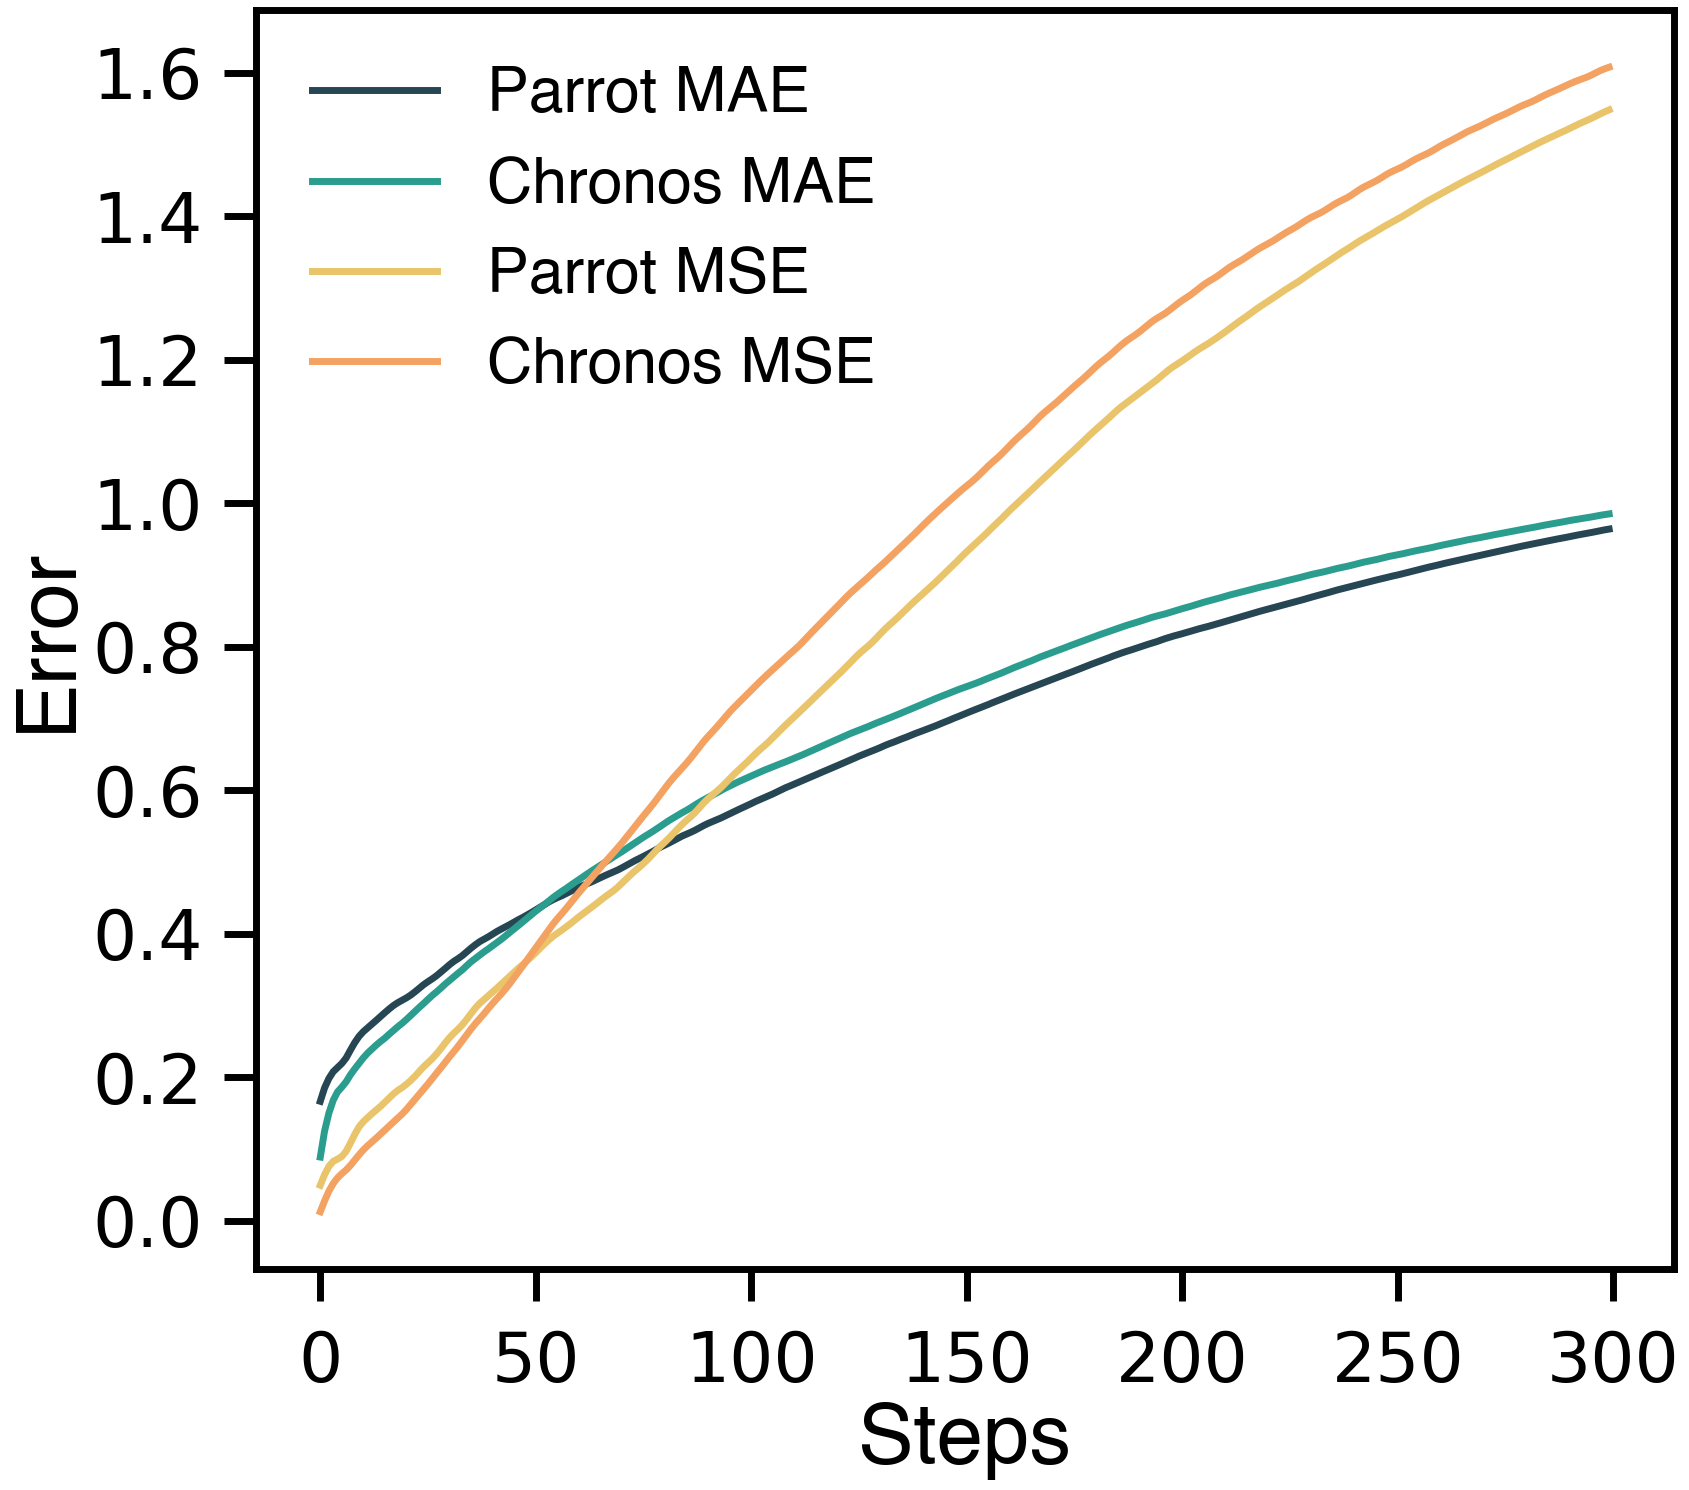

In [9]:
RE_VAL = 900 # Change this to 300, 600, 900, 1200


X_pca = np.load(f"./von_karman_street/vortex_street_vorticities_Re_{RE_VAL}_pca10.pkl", allow_pickle=True)
# X_pca = np.load(f"./von_karman_street/vortex_street_pod_Re_{RE_VAL}_long.npz", allow_pickle=True)[1000:]

#downsample the data
downsamplerate = 2
data = X_pca[::downsamplerate,:]

print(f"Data shape: {data.shape}")

parrot_mse = []
parrot_mae = []
parrot_kl = []
Chronos_mse = []
Chronos_mae = []
Chronos_kl = []

parrot_mse_rolling = list()
parrot_mae_rolling = list()
Chronos_mse_rolling = list()
Chronos_mae_rolling = list()

context_length = 512
forecast_length = 300
num_ic = 200
num_modes = 2
evaluated_steps = 50

traj = data[:,:num_modes]
# normalize the trajectory
traj = (traj - np.mean(traj, axis=0)) / np.std(traj, axis=0)

for ic in range(num_ic):

  start = random.randint(0, data.shape[0] - context_length - forecast_length)
  traj_context = traj[start:start+context_length,:]
  traj_true = traj[start+context_length:start+context_length+forecast_length,:]

  traj_pred = np.zeros_like(traj_true)
  Parrot_pred = np.zeros_like(traj_true)

  for mode in range(num_modes):

    forecast = pipeline.predict(
        context=torch.tensor(traj_context[:,mode]),
        prediction_length=forecast_length,
        num_samples=1,
        limit_prediction_length=False
    )
    traj_pred_single = np.mean(forecast[0, :, :].detach().numpy(), axis=0)
    #traj_pred_single = forecast[0,4,:].numpy()
    traj_pred[:,mode] = traj_pred_single

    mse_val = mse_rolling(traj_pred[:,mode], traj_true[:,mode])
    Chronos_mse_rolling.append(np.array(mse_val))
    Chronos_mse.append(mse_val[evaluated_steps])
    mae_val = mae_rolling(traj_pred[:,mode], traj_true[:,mode])
    Chronos_mae_rolling.append(np.array(mae_val))
    Chronos_mae.append(mae_val[evaluated_steps])

    best_index, min_l2_distance, Parrot_pred_single = context_parroting_forecast(traj_context[:,mode], D=15, tau=1, forecast_total_length=forecast_length)
    Parrot_pred[:,mode] = Parrot_pred_single
    
    mse_val = mse_rolling(Parrot_pred_single, traj_true[:,mode])
    parrot_mse_rolling.append(np.array(mse_val))
    parrot_mse.append(mse_val[evaluated_steps])
    mae_val = mae_rolling(Parrot_pred_single, traj_true[:,mode])
    parrot_mae_rolling.append(np.array(mae_val))
    parrot_mae.append(mae_val[evaluated_steps])

  kl_dist = estimate_kl_divergence(traj_true, traj_pred)
  if np.isinf(kl_dist):
      kl_dist = np.nan
  Chronos_kl.append(kl_dist)

  kl_dist = estimate_kl_divergence(traj_true, Parrot_pred)
  if np.isinf(kl_dist):
      kl_dist = np.nan
  parrot_kl.append(kl_dist)

parrot_average_mae = np.mean(parrot_mae_rolling, axis=0)
parrot_average_mse = np.mean(parrot_mse_rolling, axis=0)
Chronos_average_mae = np.mean(Chronos_mae_rolling, axis=0)
Chronos_average_mse = np.mean(Chronos_mse_rolling, axis=0)

print(f"Parrot MSE: {np.mean(parrot_mse)}, {np.std(parrot_mse)}")
print(f"Chronos MSE: {np.mean(Chronos_mse)}, {np.std(Chronos_mse)}")
print(f"Parrot MAE: {np.mean(parrot_mae)}, {np.std(parrot_mae)}")
print(f"Chronos MAE: {np.mean(Chronos_mae)}, {np.std(Chronos_mae)}")
print(f"average Parrot KL: {np.nanmean(parrot_kl)}, {np.nanstd(parrot_kl)}")
print(f"average Chronos KL: {np.nanmean(Chronos_kl)}, {np.nanstd(Chronos_kl)}")


colors = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]

# Plot Average VPT vs. Context Length for each equation
fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_linewidth(5)
  #ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(17,15)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel(r'Steps', fontname="Helvetica", fontsize = 60)
plt.ylabel(r'Error', fontname="Helvetica", fontsize = 60)

plt.plot(parrot_average_mae, lw=5, ls='-', alpha=1, color=colors[0], label='Parrot MAE')
plt.plot(Chronos_average_mae, lw=5, ls='-', alpha=1, color=colors[1], label='Chronos MAE')
plt.plot(parrot_average_mse, lw=5, ls='-', alpha=1, color=colors[2], label='Parrot MSE')
plt.plot(Chronos_average_mse, lw=5, ls='-', alpha=1, color=colors[3], label='Chronos MSE')

#plt.xscale('log')
#plt.yscale('log')

#plt.xlim([.1, 10])
#plt.ylim([0, 110])

#plt.yticks([0, 50, 100])

plt.legend(loc='upper left', frameon=False, prop={'size':45, 'family': 'Helvetica'}, ncol=1)

plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

fig.set_tight_layout(True)
#plt.savefig(f'mse_rolling_compare.pdf', bbox_inches='tight')


# ECG dataset

Data from sel10 at https://www.physionet.org/content/qtdb/1.0.0/
+ The time between samples is 0.004 s

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Data shape: (67500, 1)


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Parrot MSE: 0.973930722020069, 0.6449332703920405
Chronos MSE: 1.3327041293864323, 0.9679094150756755
Parrot MAE: 0.65584697600862, 0.32470388124236893
Chronos MAE: 0.8207773933054596, 0.4123271874706306
average Parrot KL: 0.06551187232006286, 0.10191653697489698
average Chronos KL: 0.3483311750974809, 0.32028590511747007


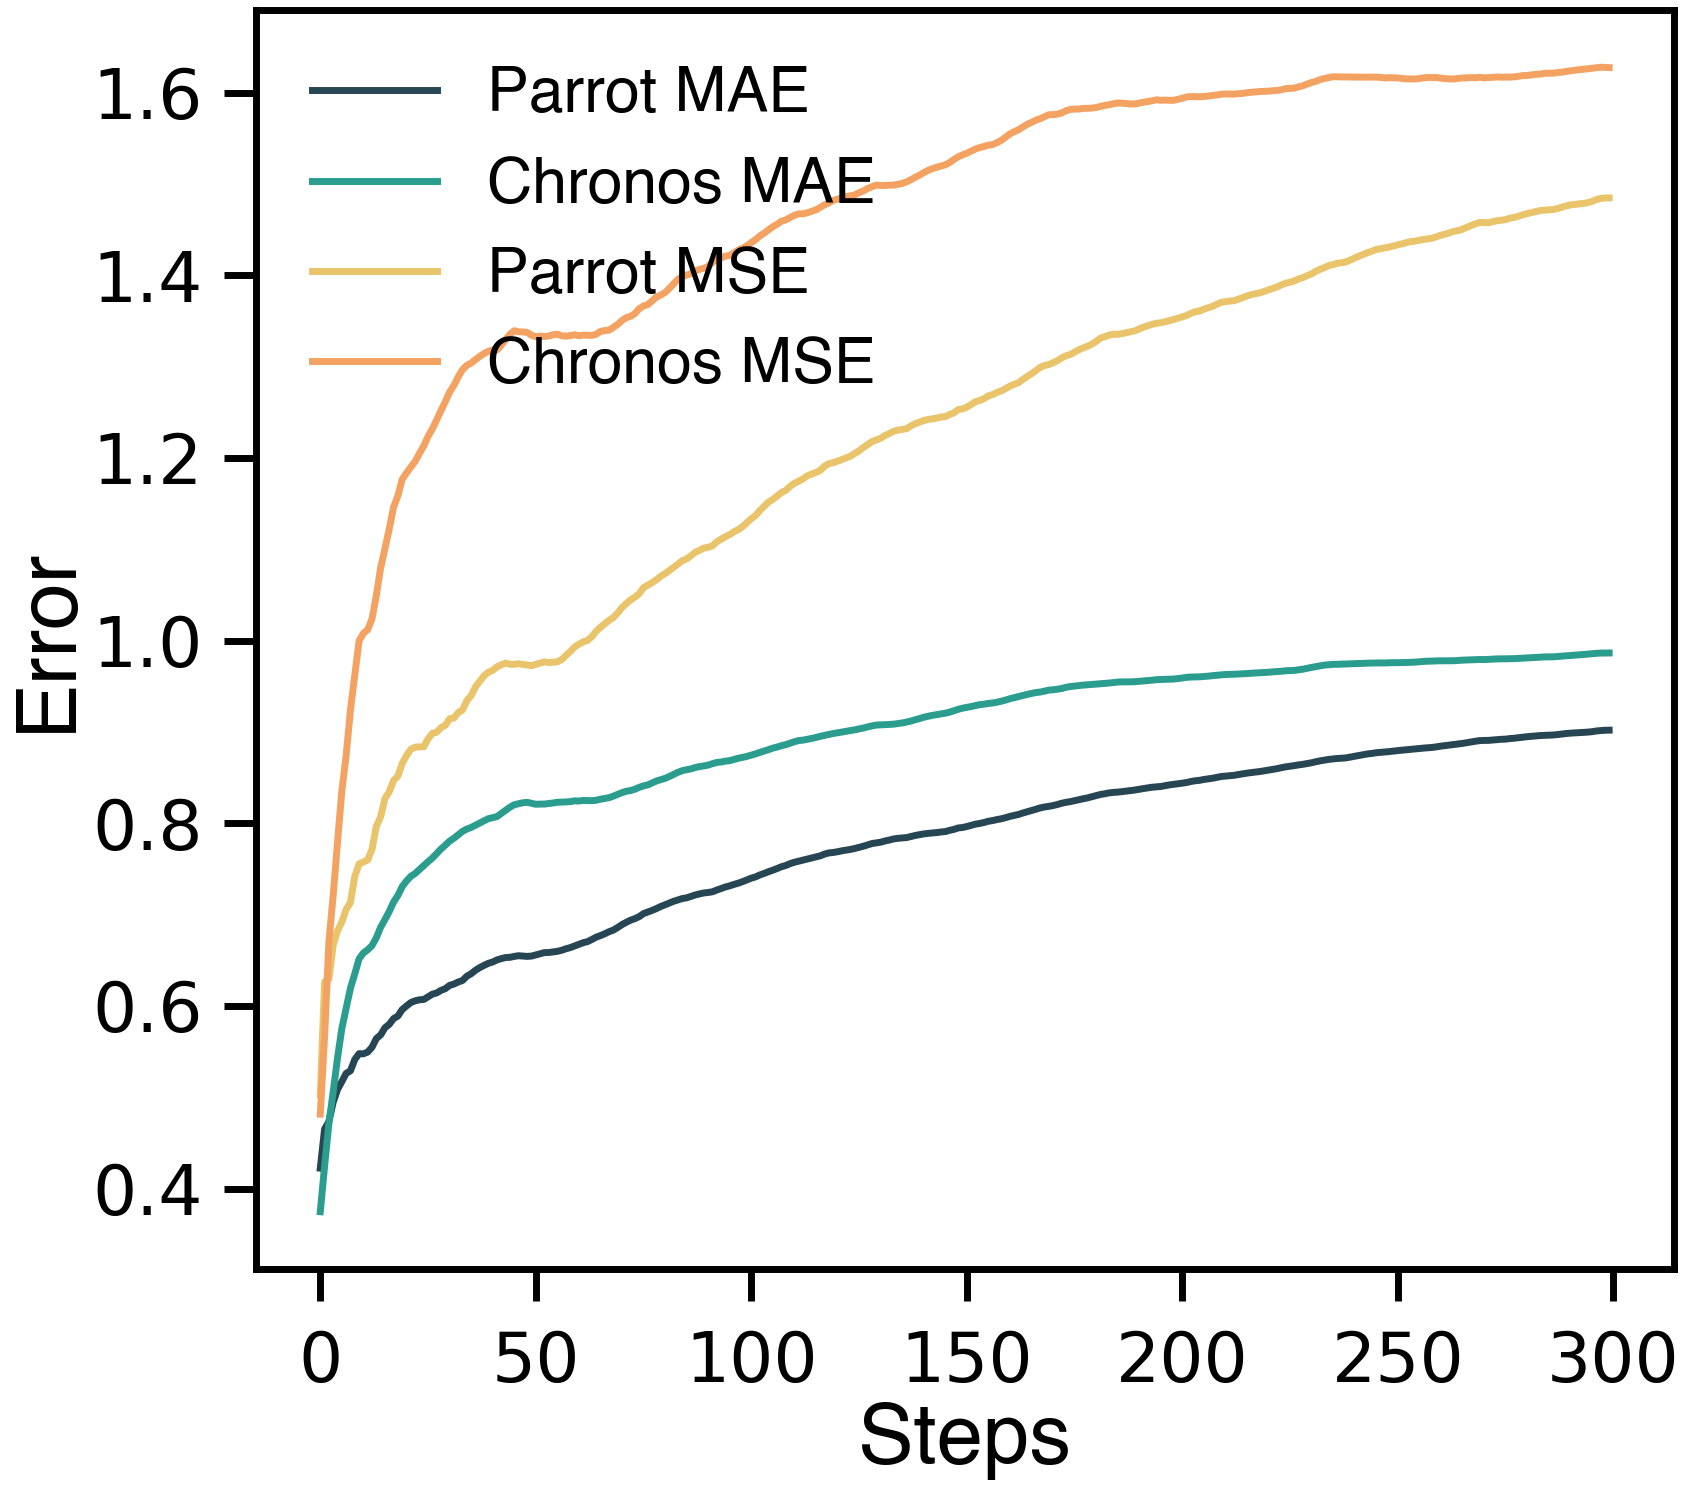

In [10]:
SPLIT = "train" # train or test

fpath = f"./electrocardiogram/ecg_train.csv.gz"
data = np.loadtxt(fpath, delimiter=",")

data = data.reshape(-1, 1)

#downsample the data
downsamplerate = 1
data = data[::downsamplerate,:]

print(f"Data shape: {data.shape}")

parrot_mse = []
parrot_mae = []
parrot_kl = []
Chronos_mse = []
Chronos_mae = []
Chronos_kl = []

parrot_mse_rolling = list()
parrot_mae_rolling = list()
Chronos_mse_rolling = list()
Chronos_mae_rolling = list()

context_length = 512
forecast_length = 300
num_ic = 200
num_modes = 1
evaluated_steps = 50

traj = data[:,:num_modes]
# normalize the trajectory
traj = (traj - np.mean(traj, axis=0)) / np.std(traj, axis=0)

for ic in range(num_ic):

  start = random.randint(0, data.shape[0] - context_length - forecast_length)
  traj_context = traj[start:start+context_length,:]
  traj_true = traj[start+context_length:start+context_length+forecast_length,:]

  traj_pred = np.zeros_like(traj_true)
  Parrot_pred = np.zeros_like(traj_true)

  for mode in range(num_modes):

    forecast = pipeline.predict(
        context=torch.tensor(traj_context[:,mode]),
        prediction_length=forecast_length,
        num_samples=1,
        limit_prediction_length=False
    )
    traj_pred_single = np.mean(forecast[0, :, :].detach().numpy(), axis=0)
    #traj_pred_single = forecast[0,4,:].numpy()
    traj_pred[:,mode] = traj_pred_single

    mse_val = mse_rolling(traj_pred[:,mode], traj_true[:,mode])
    Chronos_mse_rolling.append(np.array(mse_val))
    Chronos_mse.append(mse_val[evaluated_steps])
    mae_val = mae_rolling(traj_pred[:,mode], traj_true[:,mode])
    Chronos_mae_rolling.append(np.array(mae_val))
    Chronos_mae.append(mae_val[evaluated_steps])

    best_index, min_l2_distance, Parrot_pred_single = context_parroting_forecast(traj_context[:,mode], D=20, tau=1, forecast_total_length=forecast_length)
    Parrot_pred[:,mode] = Parrot_pred_single
    
    mse_val = mse_rolling(Parrot_pred_single, traj_true[:,mode])
    parrot_mse_rolling.append(np.array(mse_val))
    parrot_mse.append(mse_val[evaluated_steps])
    mae_val = mae_rolling(Parrot_pred_single, traj_true[:,mode])
    parrot_mae_rolling.append(np.array(mae_val))
    parrot_mae.append(mae_val[evaluated_steps])

  kl_dist = estimate_kl_divergence(traj_true, traj_pred)
  if np.isinf(kl_dist):
      kl_dist = np.nan
  Chronos_kl.append(kl_dist)

  kl_dist = estimate_kl_divergence(traj_true, Parrot_pred)
  if np.isinf(kl_dist):
      kl_dist = np.nan
  parrot_kl.append(kl_dist)

parrot_average_mae = np.mean(parrot_mae_rolling, axis=0)
parrot_average_mse = np.mean(parrot_mse_rolling, axis=0)
Chronos_average_mae = np.mean(Chronos_mae_rolling, axis=0)
Chronos_average_mse = np.mean(Chronos_mse_rolling, axis=0)

print(f"Parrot MSE: {np.mean(parrot_mse)}, {np.std(parrot_mse)}")
print(f"Chronos MSE: {np.mean(Chronos_mse)}, {np.std(Chronos_mse)}")
print(f"Parrot MAE: {np.mean(parrot_mae)}, {np.std(parrot_mae)}")
print(f"Chronos MAE: {np.mean(Chronos_mae)}, {np.std(Chronos_mae)}")
print(f"average Parrot KL: {np.nanmean(parrot_kl)}, {np.nanstd(parrot_kl)}")
print(f"average Chronos KL: {np.nanmean(Chronos_kl)}, {np.nanstd(Chronos_kl)}")


colors = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]

# Plot Average VPT vs. Context Length for each equation
fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_linewidth(5)
  #ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(17,15)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel(r'Steps', fontname="Helvetica", fontsize = 60)
plt.ylabel(r'Error', fontname="Helvetica", fontsize = 60)

plt.plot(parrot_average_mae, lw=5, ls='-', alpha=1, color=colors[0], label='Parrot MAE')
plt.plot(Chronos_average_mae, lw=5, ls='-', alpha=1, color=colors[1], label='Chronos MAE')
plt.plot(parrot_average_mse, lw=5, ls='-', alpha=1, color=colors[2], label='Parrot MSE')
plt.plot(Chronos_average_mse, lw=5, ls='-', alpha=1, color=colors[3], label='Chronos MSE')

#plt.xscale('log')
#plt.yscale('log')

#plt.xlim([.1, 10])
#plt.ylim([0, 110])

#plt.yticks([0, 50, 100])

plt.legend(loc='upper left', frameon=False, prop={'size':45, 'family': 'Helvetica'}, ncol=1)

plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

fig.set_tight_layout(True)
#plt.savefig(f'mse_rolling_compare.pdf', bbox_inches='tight')

# Electronic circuit

+ Dataset R1 from 

https://www.sciencedirect.com/science/article/pii/S235234091931368X#fig1
https://zenodo.org/records/3521009

+ The file name `R1/ST_100_1` means Network structure 1, coupling strength 100, replicate 1. This folder only contains network architecture R1, which corresponds to a fixed coupling matrix among 28 oscillators.

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Data shape: (30000, 28)


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Parrot MSE: 0.011278954215250426, 0.014860921403518535
Chronos MSE: 0.024725741372591686, 0.03732484227421871
Parrot MAE: 0.07845998629372, 0.048607475888996325
Chronos MAE: 0.11147887861525943, 0.07062235542756888
average Parrot KL: 0.5428719674713918, 0.1519926827747497
average Chronos KL: 0.6304048474205974, 0.11828629562837521


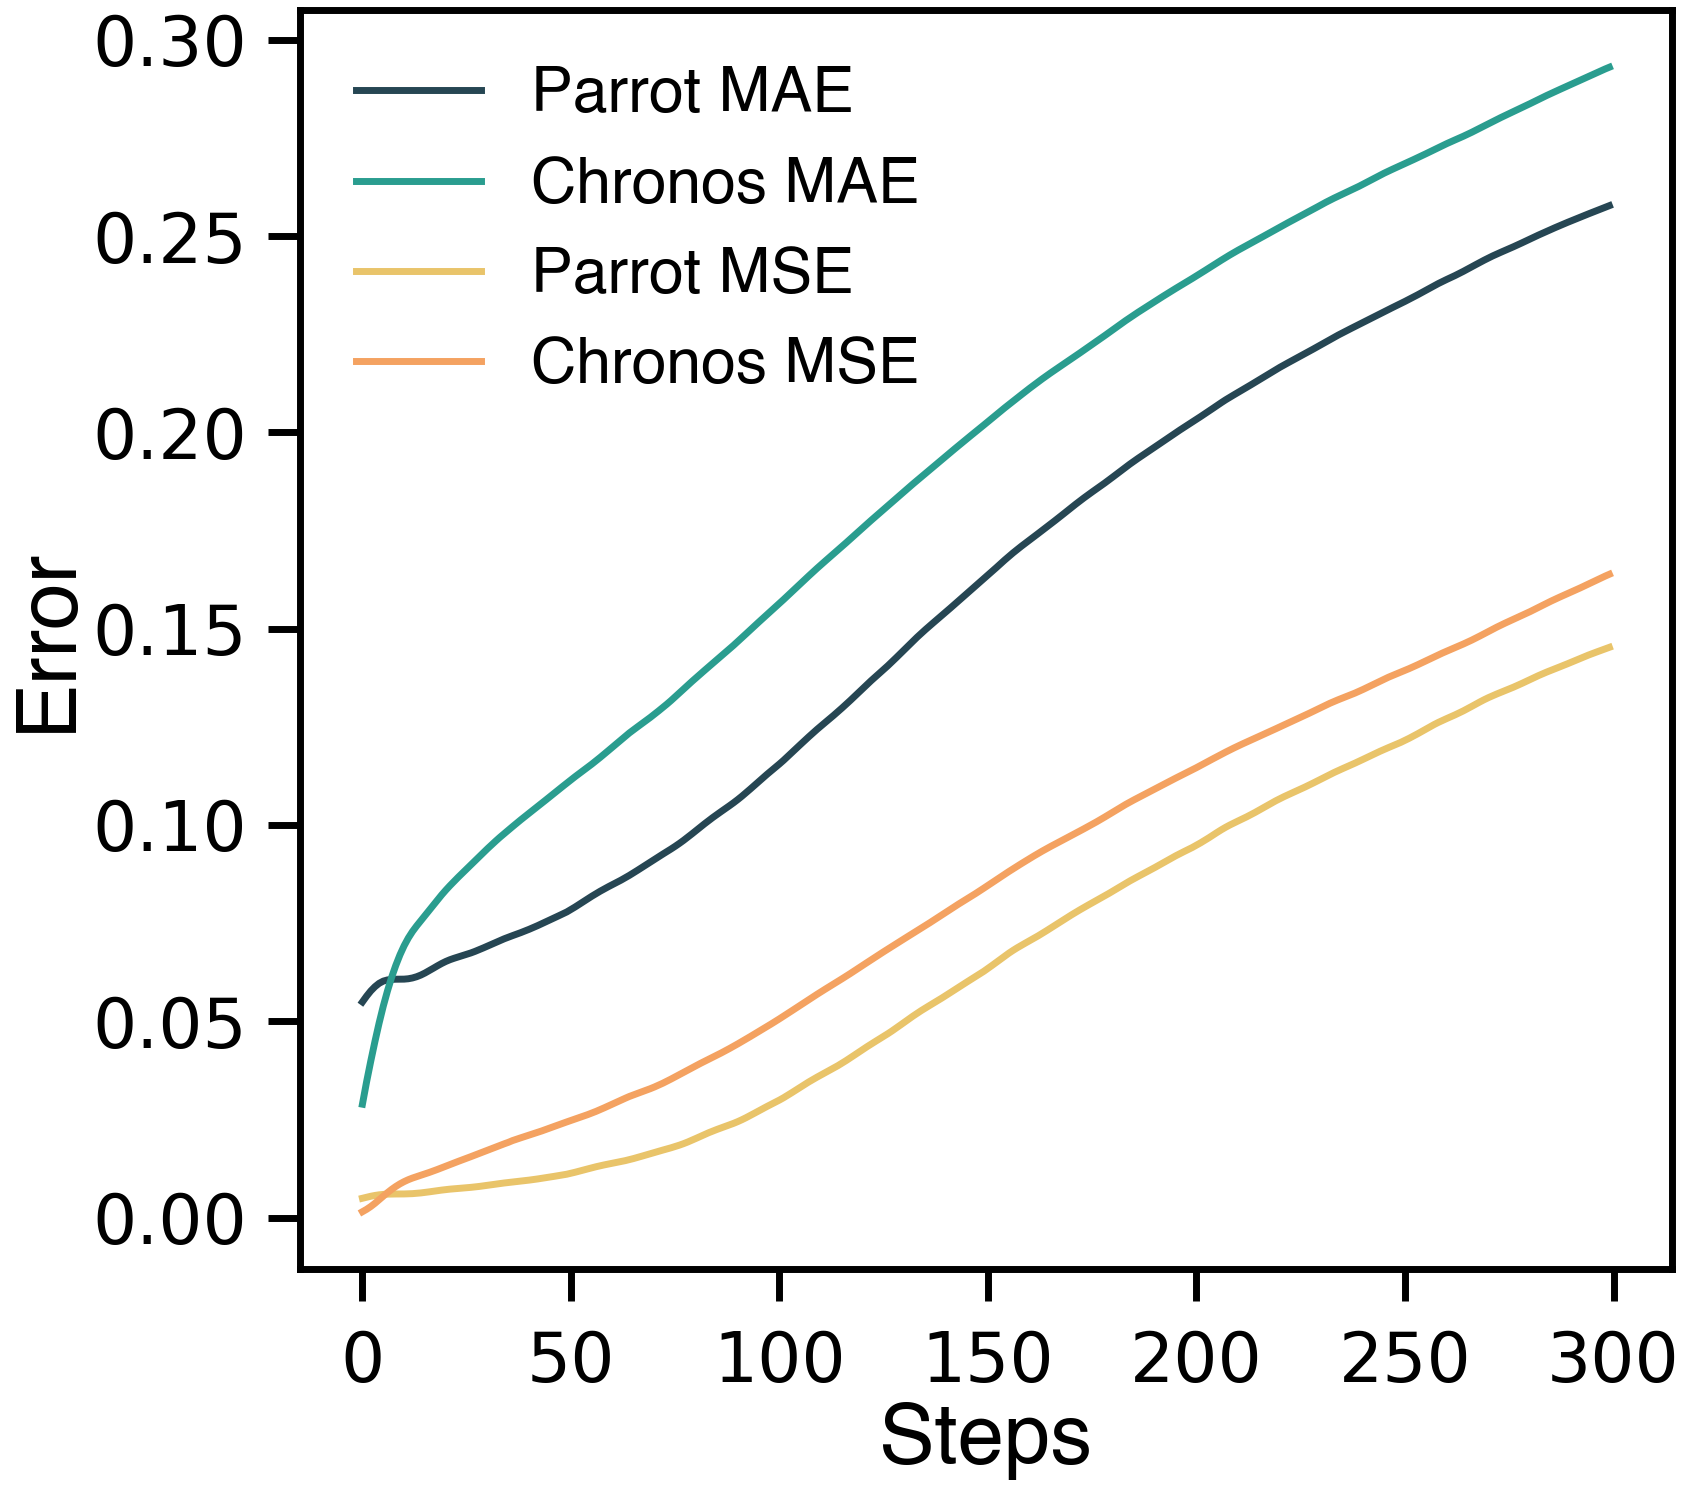

In [11]:
# fpath = "/Users/william/Dropbox/forecast datasets/electronic_circuit/R1/ST_0_1.dat"
fpath = "./electronic_circuit/R1/ST_1_1.dat"
data = np.loadtxt(fpath)

#downsample the data
downsamplerate = 1
data = data[::downsamplerate,:]

print(f"Data shape: {data.shape}")

parrot_mse = []
parrot_mae = []
parrot_kl = []
Chronos_mse = []
Chronos_mae = []
Chronos_kl = []

parrot_mse_rolling = list()
parrot_mae_rolling = list()
Chronos_mse_rolling = list()
Chronos_mae_rolling = list()

context_length = 512
forecast_length = 300
num_ic = 50
num_modes = 28
evaluated_steps = 50

traj = data[:,:num_modes]
# normalize the trajectory
traj = (traj - np.mean(traj, axis=0)) / np.std(traj, axis=0)

for ic in range(num_ic):

  start = random.randint(0, data.shape[0] - context_length - forecast_length)
  traj_context = traj[start:start+context_length,:]
  traj_true = traj[start+context_length:start+context_length+forecast_length,:]

  traj_pred = np.zeros_like(traj_true)
  Parrot_pred = np.zeros_like(traj_true)

  for mode in range(num_modes):

    forecast = pipeline.predict(
        context=torch.tensor(traj_context[:,mode]),
        prediction_length=forecast_length,
        num_samples=1,
        limit_prediction_length=False
    )
    traj_pred_single = np.mean(forecast[0, :, :].detach().numpy(), axis=0)
    #traj_pred_single = forecast[0,4,:].numpy()
    traj_pred[:,mode] = traj_pred_single

    mse_val = mse_rolling(traj_pred[:,mode], traj_true[:,mode])
    Chronos_mse_rolling.append(np.array(mse_val))
    Chronos_mse.append(mse_val[evaluated_steps])
    mae_val = mae_rolling(traj_pred[:,mode], traj_true[:,mode])
    Chronos_mae_rolling.append(np.array(mae_val))
    Chronos_mae.append(mae_val[evaluated_steps])

    best_index, min_l2_distance, Parrot_pred_single = context_parroting_forecast(traj_context[:,mode], D=20, tau=1, forecast_total_length=forecast_length)
    Parrot_pred[:,mode] = Parrot_pred_single
    
    mse_val = mse_rolling(Parrot_pred_single, traj_true[:,mode])
    parrot_mse_rolling.append(np.array(mse_val))
    parrot_mse.append(mse_val[evaluated_steps])
    mae_val = mae_rolling(Parrot_pred_single, traj_true[:,mode])
    parrot_mae_rolling.append(np.array(mae_val))
    parrot_mae.append(mae_val[evaluated_steps])

  kl_dist = estimate_kl_divergence(traj_true, traj_pred)
  if np.isinf(kl_dist):
      kl_dist = np.nan
  Chronos_kl.append(kl_dist)

  kl_dist = estimate_kl_divergence(traj_true, Parrot_pred)
  if np.isinf(kl_dist):
      kl_dist = np.nan
  parrot_kl.append(kl_dist)

parrot_average_mae = np.mean(parrot_mae_rolling, axis=0)
parrot_average_mse = np.mean(parrot_mse_rolling, axis=0)
Chronos_average_mae = np.mean(Chronos_mae_rolling, axis=0)
Chronos_average_mse = np.mean(Chronos_mse_rolling, axis=0)

print(f"Parrot MSE: {np.mean(parrot_mse)}, {np.std(parrot_mse)}")
print(f"Chronos MSE: {np.mean(Chronos_mse)}, {np.std(Chronos_mse)}")
print(f"Parrot MAE: {np.mean(parrot_mae)}, {np.std(parrot_mae)}")
print(f"Chronos MAE: {np.mean(Chronos_mae)}, {np.std(Chronos_mae)}")
print(f"average Parrot KL: {np.nanmean(parrot_kl)}, {np.nanstd(parrot_kl)}")
print(f"average Chronos KL: {np.nanmean(Chronos_kl)}, {np.nanstd(Chronos_kl)}")


colors = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]

# Plot Average VPT vs. Context Length for each equation
fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_linewidth(5)
  #ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(17,15)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel(r'Steps', fontname="Helvetica", fontsize = 60)
plt.ylabel(r'Error', fontname="Helvetica", fontsize = 60)

plt.plot(parrot_average_mae, lw=5, ls='-', alpha=1, color=colors[0], label='Parrot MAE')
plt.plot(Chronos_average_mae, lw=5, ls='-', alpha=1, color=colors[1], label='Chronos MAE')
plt.plot(parrot_average_mse, lw=5, ls='-', alpha=1, color=colors[2], label='Parrot MSE')
plt.plot(Chronos_average_mse, lw=5, ls='-', alpha=1, color=colors[3], label='Chronos MSE')

#plt.xscale('log')
#plt.yscale('log')

#plt.xlim([.1, 10])
#plt.ylim([0, 110])

#plt.yticks([0, 50, 100])

plt.legend(loc='upper left', frameon=False, prop={'size':45, 'family': 'Helvetica'}, ncol=1)

plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

fig.set_tight_layout(True)
#plt.savefig(f'mse_rolling_compare.pdf', bbox_inches='tight')

We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 


Data shape: (2001, 23)


We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
We recommend keeping prediction length <= 64. The quality of l

Parrot MSE: 2.484190928482036e-05, 3.7819710773930145e-07
Chronos MSE: 0.008853558427988767, 0.007133365897030598
Parrot MAE: 0.004486986482539198, 4.761708902818524e-05
Chronos MAE: 0.07174789822748893, 0.029292237086297888
average Parrot KL: 2.119543684811848e-06, 2.170740392827221e-05
average Chronos KL: 0.5374547551750245, 0.08729427458486902


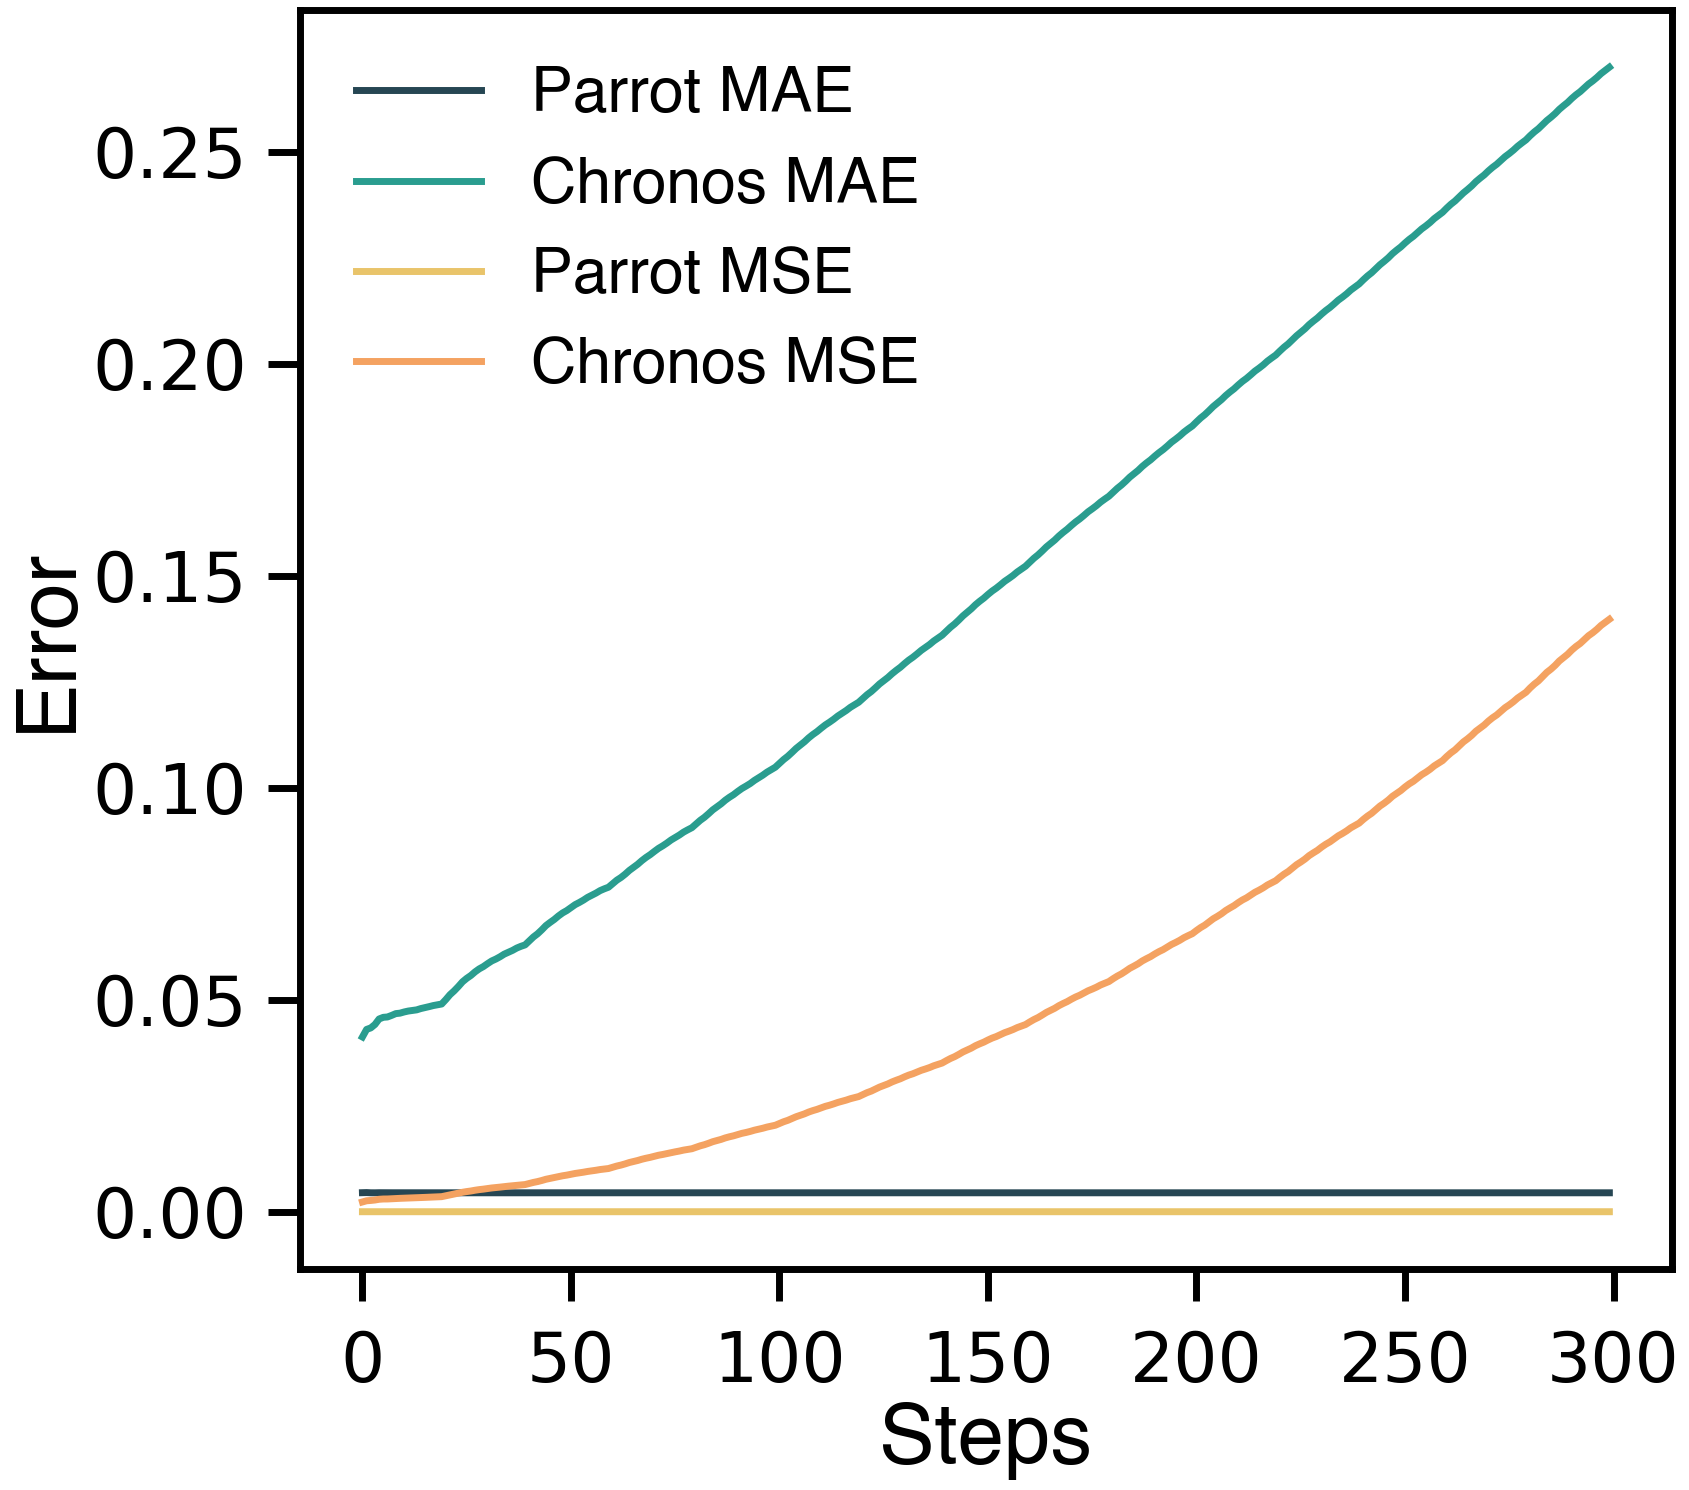

In [ ]:
fpath = "./kuramoto/oscillator_glass.npy"
data = np.load(fpath)

#downsample the data
downsamplerate = 1
data = data[::downsamplerate,:]

print(f"Data shape: {data.shape}")

parrot_mse = []
parrot_mae = []
parrot_kl = []
Chronos_mse = []
Chronos_mae = []
Chronos_kl = []

parrot_mse_rolling = list()
parrot_mae_rolling = list()
Chronos_mse_rolling = list()
Chronos_mae_rolling = list()

context_length = 512
forecast_length = 300
num_ic = 50
num_modes = 23
evaluated_steps = 50

traj = np.sin(data[:,:num_modes])
# normalize the trajectory
traj = (traj - np.mean(traj, axis=0)) / np.std(traj, axis=0)

for ic in range(num_ic):

  start = random.randint(0, data.shape[0] - context_length - forecast_length)
  traj_context = traj[start:start+context_length,:]
  traj_true = traj[start+context_length:start+context_length+forecast_length,:]

  traj_pred = np.zeros_like(traj_true)
  Parrot_pred = np.zeros_like(traj_true)

  for mode in range(num_modes):

    forecast = pipeline.predict(
        context=torch.tensor(traj_context[:,mode]),
        prediction_length=forecast_length,
        num_samples=1,
        limit_prediction_length=False
    )
    traj_pred_single = np.mean(forecast[0, :, :].detach().numpy(), axis=0)
    #traj_pred_single = forecast[0,4,:].numpy()
    traj_pred[:,mode] = traj_pred_single

    mse_val = mse_rolling(traj_pred[:,mode], traj_true[:,mode])
    Chronos_mse_rolling.append(np.array(mse_val))
    Chronos_mse.append(mse_val[evaluated_steps])
    mae_val = mae_rolling(traj_pred[:,mode], traj_true[:,mode])
    Chronos_mae_rolling.append(np.array(mae_val))
    Chronos_mae.append(mae_val[evaluated_steps])

    best_index, min_l2_distance, Parrot_pred_single = context_parroting_forecast(traj_context[:,mode], D=20, tau=1, forecast_total_length=forecast_length)
    Parrot_pred[:,mode] = Parrot_pred_single

    mse_val = mse_rolling(Parrot_pred_single, traj_true[:,mode])
    parrot_mse_rolling.append(np.array(mse_val))
    parrot_mse.append(mse_val[evaluated_steps])
    mae_val = mae_rolling(Parrot_pred_single, traj_true[:,mode])
    parrot_mae_rolling.append(np.array(mae_val))
    parrot_mae.append(mae_val[evaluated_steps])

  kl_dist = estimate_kl_divergence(traj_true, traj_pred)
  if np.isinf(kl_dist):
      kl_dist = np.nan
  Chronos_kl.append(kl_dist)

  kl_dist = estimate_kl_divergence(traj_true, Parrot_pred)
  if np.isinf(kl_dist):
      kl_dist = np.nan
  parrot_kl.append(kl_dist)

parrot_average_mae = np.mean(parrot_mae_rolling, axis=0)
parrot_average_mse = np.mean(parrot_mse_rolling, axis=0)
Chronos_average_mae = np.mean(Chronos_mae_rolling, axis=0)
Chronos_average_mse = np.mean(Chronos_mse_rolling, axis=0)

print(f"Parrot MSE: {np.mean(parrot_mse)}, {np.std(parrot_mse)}")
print(f"Chronos MSE: {np.mean(Chronos_mse)}, {np.std(Chronos_mse)}")
print(f"Parrot MAE: {np.mean(parrot_mae)}, {np.std(parrot_mae)}")
print(f"Chronos MAE: {np.mean(Chronos_mae)}, {np.std(Chronos_mae)}")
print(f"average Parrot KL: {np.nanmean(parrot_kl)}, {np.nanstd(parrot_kl)}")
print(f"average Chronos KL: {np.nanmean(Chronos_kl)}, {np.nanstd(Chronos_kl)}")


colors = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]

# Plot Average VPT vs. Context Length for each equation
fig = plt.figure()
ax = fig.add_subplot(111)

for axis in ['bottom','left']:
  ax.spines[axis].set_linewidth(5)
for axis in ['top','right']:
  ax.spines[axis].set_linewidth(5)
  #ax.spines[axis].set_visible(False)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

fig.set_size_inches(17,15)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel(r'Steps', fontname="Helvetica", fontsize = 60)
plt.ylabel(r'Error', fontname="Helvetica", fontsize = 60)

plt.plot(parrot_average_mae, lw=5, ls='-', alpha=1, color=colors[0], label='Parrot MAE')
plt.plot(Chronos_average_mae, lw=5, ls='-', alpha=1, color=colors[1], label='Chronos MAE')
plt.plot(parrot_average_mse, lw=5, ls='-', alpha=1, color=colors[2], label='Parrot MSE')
plt.plot(Chronos_average_mse, lw=5, ls='-', alpha=1, color=colors[3], label='Chronos MSE')

plt.legend(loc='upper left', frameon=False, prop={'size':45, 'family': 'Helvetica'}, ncol=1)

plt.gca().tick_params(axis='y', pad=15, size=23, width=5)
plt.gca().tick_params(axis='x', pad=20, size=23, width=5)

fig.set_tight_layout(True)
#plt.savefig(f'mse_rolling_compare.pdf', bbox_inches='tight')